# Data carving with post-selection inference


## Background

In post-selection inference (PoSI), we want to run a classic linear regression on a subset of features that have been selected by some algorithm. The statistical quantity of interest is a one-dimensional term $\eta_j^T g=\beta^0_j$, which is the inner product of a row from the matrix $[(X^TX)^{-1}X^T]_{j:}$ and the signal component of the response for a model of additive error: $y=g(x)+e$, $e\sim N(0,\sigma^2 I_n)$, where $g$ is usually assumed to be linear. For example, if the Lasso is run for a fixed value of $\lambda$, then we could consider running a linear regression on only those coordinates which it selected non-zero coefficients for.

$$
M = \{j: \beta^{\text{lasso}}_\lambda \neq 0\} \subset \{1, \dots, p\}
$$

Recent research has shown that for the Lasso, and other algorithms (like marginal screening or forward stepwise regression), the selection event $M$ can be shown to be in bijection with a polyhedral constraints on $y$ which leads to a trunctated normal distribution (see [Lee 2016](https://projecteuclid.org/journals/annals-of-statistics/volume-44/issue-3/Exact-post-selection-inference-with-application-to-the-lasso/10.1214/15-AOS1371.full) for why this is the case).

$$
\hat\beta^{\text{PoSI}}_j = \eta^T_{M_j}y \sim \text{TN}(\beta_j^{M}, \sigma^2_M \|\eta_{M_j}\|^2_2, V^{-}(y), V^{+}(y))
$$

If this estimator is combined with another portion of data that was unused in the Lasso alogithm,

$$
\hat\beta^{\text{OLS}}_j = \eta^T_{M_j}y \sim N(\beta_j^{M}, \sigma^2_M \|\eta_{M_j}\|^2_2)
$$

Then the (weighted) sum of these two coefficients will follow an SNTN distribution, where $w_A$ and $w_B$ are the relative sample sizes which sum to one.

$$
\begin{align*}
\hat\beta^{\text{carve}}_j &= w_A \hat\beta^{\text{OLS}}_j + w_B \hat\beta^{\text{PoSI}}_j \\
&\sim SNTN(\beta_j^{M}, \sigma^2_M \|\eta^A_{M_j}\|^2_2, \beta_j^{M}, \sigma^2_M \|\eta^B_{M_j}\|^2_2, w_A, w_B)
\end{align*}
$$

## Examples

The rest of this notebook will provide a tutorial on how to obtain inference with the SNTN distribution for data carving-PoSI. The Wisconsin Breast Cancer dataset will be used, and both the Lasso and marginal screening will be considered. A type-1 error rate of 5% is set with `alpha`.

All examples will be derived from scratch, with the convenience wrapper at the end being present.

In [1]:
import sys
import os
sys.path.append('..')

# Load external packages
import numpy as np
import pandas as pd
import plotnine as pn
from scipy.stats import norm
from glmnet import ElasticNet
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
# Load SNTN utilities
from sntn.dists import nts, tnorm
from sntn.posi import lasso, marginal_screen

# Checking numerical stability of solutions
kkt_tol = 5e-3

# Set up null-hypothesis testing
alpha = 0.05
null_beta = 0

## (1) Prepare data for carving

We will use 10% of the data for carving, creating a screening and inference set, and normalizing the screening set as it will be used by approaches that select for absolute magnitude (Lasso & marginal screening)

In [2]:
# Load dataset
X, y = load_breast_cancer(return_X_y=True)
cn_X = load_breast_cancer().feature_names
n, p = X.shape

# Split data into screening and inference
pct_split = 0.5
seed = 1
X_B, X_A, y_B, y_A = train_test_split(X, y, test_size=pct_split, random_state=seed)
n_A, n_B = len(y_A), len(y_B)
w_A, w_B = n_A/n, n_B/n
# Normalize B (which will go into algorithms)
xmu = X_B.mean(0)
xse = X_B.std(0,ddof=1)
Xtil_B = (X_B - xmu) / xse
# Put A on the same scale as B so the coefficients have the same intepretation
Xtil_A = (X_A - xmu) / xse

# De-mean y so we don't need to fit intercept
ytil_A = y_A - y_A.mean()
ytil_B = y_B - y_B.mean()

## (2) Lasso


To begin with, we'll get the coefficients and the estimate of the variance for the PoSI and then the OLS estimator.

In [3]:
# (i) Run the Lasso for some fixed value of lambda
lamb_fix = 1e-2
lamb_path = np.array([lamb_fix*1.01, lamb_fix])  # ElasticNet wants >=2 values
mdl_lasso = ElasticNet(alpha=1, n_splits=0, standardize=False, lambda_path=lamb_path, tol=1e-20)
mdl_lasso.fit(Xtil_B, ytil_B)
bhat_lasso = mdl_lasso.coef_path_[:,1]
M_lasso = bhat_lasso != 0
cn_lasso = cn_X[M_lasso]
X_B_M = Xtil_B[:,M_lasso].copy()
# Check KKT conditions
kkt_lasso = np.abs(Xtil_B.T.dot(ytil_B - Xtil_B.dot(bhat_lasso)) / n_B)
err_kkt = np.max(np.abs(kkt_lasso[M_lasso] - lamb_fix))
assert err_kkt < kkt_tol, 'KKT conditions not met'
assert np.all(lamb_fix > kkt_lasso[~M_lasso]), 'KKT conditions not met'
n_sel = M_lasso.sum()
print(f'Lasso selected {n_sel} of {p} features for lambda={lamb_fix} (KKT-err={err_kkt:0.5f})')

# (ii) Run OLS on the screening portion
igram_B_M = np.linalg.inv(np.dot(X_B_M.T, X_B_M))
eta_B_M = np.dot(X_B_M, igram_B_M)
bhat_B = np.dot(eta_B_M.T, ytil_B)

# (iii) Run inference on the classical held-out portion
X_A_M = Xtil_A[:,M_lasso].copy()
igram_A_M = np.linalg.inv(np.dot(X_A_M.T, X_A_M))
eta_A_M = np.dot(X_A_M, igram_A_M)
bhat_A = np.dot(eta_A_M.T, ytil_A)

# (iv) Use held-out portion to estimate variance of the error
resid_A = ytil_A - np.dot(X_A_M, bhat_A)
sigma2_A = np.sum(resid_A**2) / (len(X_A) - M_lasso.sum())
tau21 = sigma2_A * np.sum(eta_A_M**2,0)

Lasso selected 10 of 30 features for lambda=0.01 (KKT-err=0.00000)


Following Lee's paper, we'll follow equations (4.8) to (5.6), using only A1/b1 because we are only considering partial inference.

In [4]:
# (v) Calculate the polyhedral constraints
sign_M = np.diag(np.sign(bhat_lasso[M_lasso]).astype(int))
A = -np.dot(sign_M, eta_B_M.T)
# Note, that lambda is multiplied by n_B since the solution below solves for the non-normalized version
b = -n_B * lamb_fix * np.dot(sign_M, np.dot(igram_B_M, sign_M.diagonal()))
# Check for constraint error
assert  np.all(A.dot(ytil_B) <= b), 'Polyhedral constraint not met!'

# (vi) Calculate the truncated normal values (4.8 to 5.6 for Lee's paper, using only A1/A2)
tau22 = sigma2_A * np.sum(eta_B_M**2,0)
D = np.sqrt(tau22 / sigma2_A)
V = eta_B_M / D
R = np.squeeze(np.dstack([np.dot(np.diag(np.ones(n_B)) - np.outer(V[:,j],V[:,j]),ytil_B)  for j in range(n_sel)]))
AV = np.dot(A, V)
AR = A.dot(R)
nu = (b.reshape([n_sel,1]) - AR) / AV
idx_neg = AV < 0
idx_pos = AV > 0
a = np.max(np.where(idx_neg, nu, -np.inf),0) * D
b = np.min(np.where(idx_pos, nu, +np.inf),0) * D

We can now set up all of the specific distributions.

In [5]:
# Signs can be used to determine direction of hypothesis test
is_sign_neg = np.sign(bhat_lasso[M_lasso])==-1

# (i) PoSI with the Lasso
dist_tnorm = tnorm(null_beta, tau22, a, b)
pval_tnorm = dist_tnorm.cdf(bhat_B)
pval_tnorm = np.where(is_sign_neg, pval_tnorm, 1-pval_tnorm)
res_tnorm = pd.DataFrame({'mdl':'Screening','cn':cn_lasso,'bhat':bhat_B, 'pval':pval_tnorm})
res_tnorm = pd.concat(objs=[res_tnorm, pd.DataFrame(dist_tnorm.conf_int(bhat_B, alpha),columns=['lb','ub'])],axis=1)

# (ii) OLS on inference set
dist_norm = norm(loc=null_beta, scale=np.sqrt(tau21))
pval_norm = dist_norm.cdf(bhat_A)
pval_norm = np.where(is_sign_neg, pval_norm, 1-pval_norm)
res_norm = pd.DataFrame({'mdl':'Splitting','cn':cn_lasso, 'bhat':bhat_A, 'pval':pval_norm})
res_norm = pd.concat(objs=[res_norm, pd.DataFrame(np.vstack(norm(bhat_A, np.sqrt(tau21)).interval(1-alpha)).T,columns=['lb','ub'])],axis=1)

# (iii) Data carving on both
bhat_wAB = w_A*bhat_A + w_B*bhat_B
dist_sntn = nts(null_beta, tau21, null_beta, tau22, a, b, w_A, w_B, fix_mu=True)
pval_sntn = dist_sntn.cdf(bhat_wAB)
pval_sntn = np.where(is_sign_neg, pval_sntn, 1-pval_sntn)
res_sntn = pd.DataFrame({'mdl':'Carving','cn':cn_lasso,'bhat':bhat_wAB, 'pval':pval_sntn})
res_sntn = pd.concat(objs=[res_sntn, pd.DataFrame(np.squeeze(dist_sntn.conf_int(bhat_wAB, alpha)),columns=['lb','ub'])],axis=1)

# Combine all
res_lasso = pd.concat(objs=[res_tnorm, res_norm, res_sntn], axis=0).reset_index(drop=True)
res_lasso = res_lasso.assign(is_sig=lambda x: np.where(x['pval'] < alpha, True, False))

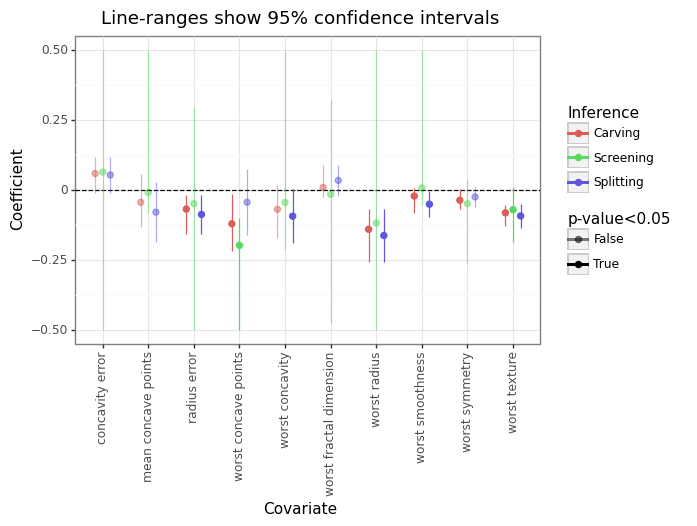

<ggplot: (438776357)>

In [12]:
pn.options.figure_size = (6,4)
posd = pn.position_dodge(0.5)
gg_lasso = (pn.ggplot(res_lasso, pn.aes(x='cn',y='bhat',color='mdl',alpha='is_sig')) + 
            pn.theme_bw() + 
            pn.geom_point(size=2,position=posd) + 
            pn.geom_hline(yintercept=0,linetype='--') +
            pn.geom_linerange(pn.aes(ymin='lb.clip(lower=-0.5)',ymax='ub.clip(upper=0.5)'),position=posd) + 
            pn.ggtitle(f'Line-ranges show {100*(1-alpha):0.0f}% confidence intervals') + 
            pn.labs(x='Covariate',y='Coefficient') + 
            pn.scale_color_discrete(name='Inference') + 
            pn.scale_alpha_manual(name=f'p-value<{alpha}',values=[0.5,1]) + 
            pn.theme(axis_text_x=pn.element_text(angle=90)))
gg_lasso

### `lasso` wrapper

Instead of calculating all of these terms by hand, a convenient lasso wrapper exists.

In [ ]:
test = lasso(lamb_fix, ytil_B, Xtil_B, frac_split=0)
test.run_inference(alpha, null_beta, sigma2=sigma2_A, run_screen=True, run_split=False, run_carve=False

### Comparing to `R`

As the [wisconsin_replicate.R](wisconsin_replicate.R) file shows, the python wrapper can get close to the same results (where the confidence intervals differ slightly due to the different root finding routines in effect).

<img src="selectiveInference_wisconsin.png" width="50%">

## (3) Marginal screening